In [1]:
import uproot
import awkward as ak
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick
import matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matplotlib.colormaps['tab10'].colors)

In [3]:
def get_path_ZZ(mass, i):
    return f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M{mass}/cat_base_selection/prod_241213c/data_{i}.root:Events"
def get_path_ZbbHtt(mass, i):
    return f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZbbHtt_v12/ZprimeToZH_ZToBB_HToTauTau_M{mass}/cat_base_selection/prod_241213c/data_{i}.root:Events"
def get_path_test(mass, i):
    return f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2016_ZZ_v12/zz_sl_signal/cat_base_selection/prod_250212/data_{i}.root"
def open_file(mass):
    return uproot.concatenate([get_path_test(mass, i) for i in [0, 1, 2, 3, 4]],
        filter_name=["boostedTau*", "Muon_*", "Electron_*", 
        #"GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_eta", "GenPart_phi", "GenPart_pt", 
        "nGenVisTau", "GenVisTau*", "LHE_*", "LHEPart*",
        "cutflow*", "*pairType*", "is*", "*enPair*", "genDau*", "dau*", "gen_*",
        "HLT_Ele*",
        #"HLT_PFMETNoMu120_PFMHTNoMu120*", "HLT_MonoCentralPFJet80_PFMETNoMu120_PFMHTNoMu120_IDTight*", "HLT_PFMET120_PFMHT120_*",
        "MET_pt", "GenMET_pt",
        "isBoosted", "fatjet_JetIdx"],
        how="zip")

ars_raw = {mass : open_file(mass)
       for mass in 
        #[2000]
        #[200, 1000, 2000, 3000, 4000, 5000] #
       # [ 200, 230,  250, 270,  300, 350, 400, 450, 500, 550, # 210, 220, 230, 240, 260, 270, 280,  320,  360,
       #          600, 650, 700, 750, 800, 850, 900, 1000, 1200,  1400, 1600,
       #          1800,  2000,   2500,  3000, 3500, 4000, 4500, 5000]
         # ZH masses
         #[500, 1000, 2000, 3000, 4000, 5000, 6000]       
          [1000]
                }
#ar_raw = {mass : ak.concatenate(ars) for mass, ars in ar_raw.items()}

In [4]:

def eff(branch_num, filter_denom):
    try:
        return ak.count_nonzero(branch_num) / ak.count_nonzero(filter_denom)
    except:
        return ak.count_nonzero(branch_num) / len(filter_denom)
def delta_phi(a, b):
    """Compute difference in angle given two angles a and b

    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)

    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)


In [17]:
def filterDeltaRLepton_genPart(ar, dR_max, dR_min=0.05):
    genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_GenPartIdx, ar.genDau1_GenPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_GenVisTauIdx, ar.genDau2_GenVisTauIdx >= 0))])
    deltaR = delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi)
    return ar[ak.fill_none((deltaR < dR_max) & (deltaR > dR_min), False)]
def filterDeltaRLepton(ar, dR_max, dR_min=0.05):
    deltaR = ar.gen_deltaR_daudau
    return ar[(deltaR < dR_max) & (deltaR > dR_min)]


def filterDeltaRDiTau_genPart(ar, dR_max=0.6, dR_min=0.05): # not sure about the deltaR cut (probably 0.3 iso cone for a tau ?)
    genDau1 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau1_GenVisTauIdx, ar.genDau1_GenVisTauIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_GenVisTauIdx, ar.genDau2_GenVisTauIdx >= 0))])
    deltaR = delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi)
    return ar[ak.fill_none((deltaR < dR_max) & (deltaR > dR_min), False)]
def filterDeltaRDiTau(ar, dR_max=0.6, dR_min=0.05): # not sure about the deltaR cut (probably 0.3 iso cone for a tau ?)
    return filterDeltaRLepton(ar, dR_max, dR_min)

def filterDeltaR(ar, pairType):
    if pairType == 0: return filterDeltaRLepton(ar, dR_max=500, dR_min=0.5)
    elif pairType == 1: return filterDeltaRLepton(ar, dR_max=500, dR_min=0.5)
    elif pairType == 2: return filterDeltaRDiTau(ar, dR_max=500, dR_min=0.5)
    else: raise ValueError()
# def genDaus(ar):
#     genpart = ak.firsts(ar.GenPart[ak.drop_none(ak.singletons(ar.genDau1_genPartIdx))])
#     ar = ak.with_field(
#         ar,
#         ak.where((ar.GenPairType >= 0) & (ar.GenPairType <= 1), 
#                      genpart[["pt", "eta", "phi"]],
#                      ak.where(ar.GenPairType == 2,
#                               ak.firsts(ar.GenVisTau)[["pt", "eta", "phi"]],
#                               None)
#                      ),
#         "genDau1"
#     )
#     return ar
def filterDetectorAcceptance_genPart(ar, pairType):
    if pairType < 2:
        genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_GenPartIdx, ar.genDau1_GenPartIdx >= 0))])
    else:
        genDau1 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau1_GenVisTauIdx, ar.genDau1_GenVisTauIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_GenVisTauIdx, ar.genDau2_GenVisTauIdx >= 0))])
    if pairType == 0: # values are kind of random
        dau1_sel = (genDau1.pt > 20 ) & (genDau1.eta < 2.4)
    elif pairType == 1:
        dau1_sel = (genDau1.pt > 20 ) & (genDau1.eta < 2.5)
    else:
        dau1_sel = (genDau1.pt > 20 ) & (genDau1.eta < 2.5)
    dau2_sel = (genDau2.pt > 20 ) & (genDau2.eta < 2.5) 
    return ak.fill_none(dau1_sel & dau2_sel, False)
def filterDetectorAcceptance(ar, pairType):
    if pairType == 2:
        dau1_sel = (ar.genDau1_pt > 40 ) & (ar.genDau1_eta < 2.1)
        dau2_sel = (ar.genDau2_pt > 40 ) & (ar.genDau2_eta < 2.1)
    else:
        if pairType == 0:
            dau1_sel = (ar.genDau1_pt > 20 ) & (ar.genDau1_eta < 2.4)
        elif pairType == 1:
            dau1_sel = (ar.genDau1_pt > 25 ) & (ar.genDau1_eta < 2.5)
        else: raise ValueError()
        dau2_sel = (ar.genDau2_pt > 20 ) & (ar.genDau2_eta < 2.5) 
    return dau1_sel & dau2_sel
def passMETTrigger(ar):
    return ar.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight | ar.HLT_MonoCentralPFJet80_PFMETNoMu120_PFMHTNoMu120_IDTight | ar.HLT_PFMET120_PFMHT120_IDTight
def passMETOffline(ar):
    return ar.MET_pt > 180
def apply_filter(ar, filter_fct, *args, **kwargs):
    return ar[filter_fct(ar, *args, **kwargs)]
min_mass_threshold = 500

In [18]:
ars_mutau = {mass:filterDeltaRLepton(apply_filter(ar[ar.genPairType == 0], filterDetectorAcceptance, 0), dR_max=500, dR_min=0.5) for mass, ar in ars_raw.items()}
ars_etau = {mass:filterDeltaRLepton(apply_filter(ar[ar.genPairType == 1], filterDetectorAcceptance, 1), dR_max=500, dR_min=0.5) for mass, ar in ars_raw.items()}
ars_tautau = {mass:filterDeltaRDiTau(apply_filter(ar[ar.genPairType == 2], filterDetectorAcceptance, 2), dR_max=500, dR_min=0.5) for mass, ar in ars_raw.items()}
ars_pairType = {0:ars_mutau, 1:ars_etau, 2:ars_tautau}

<Axes: xlabel='X resonance mass (GeV)'>

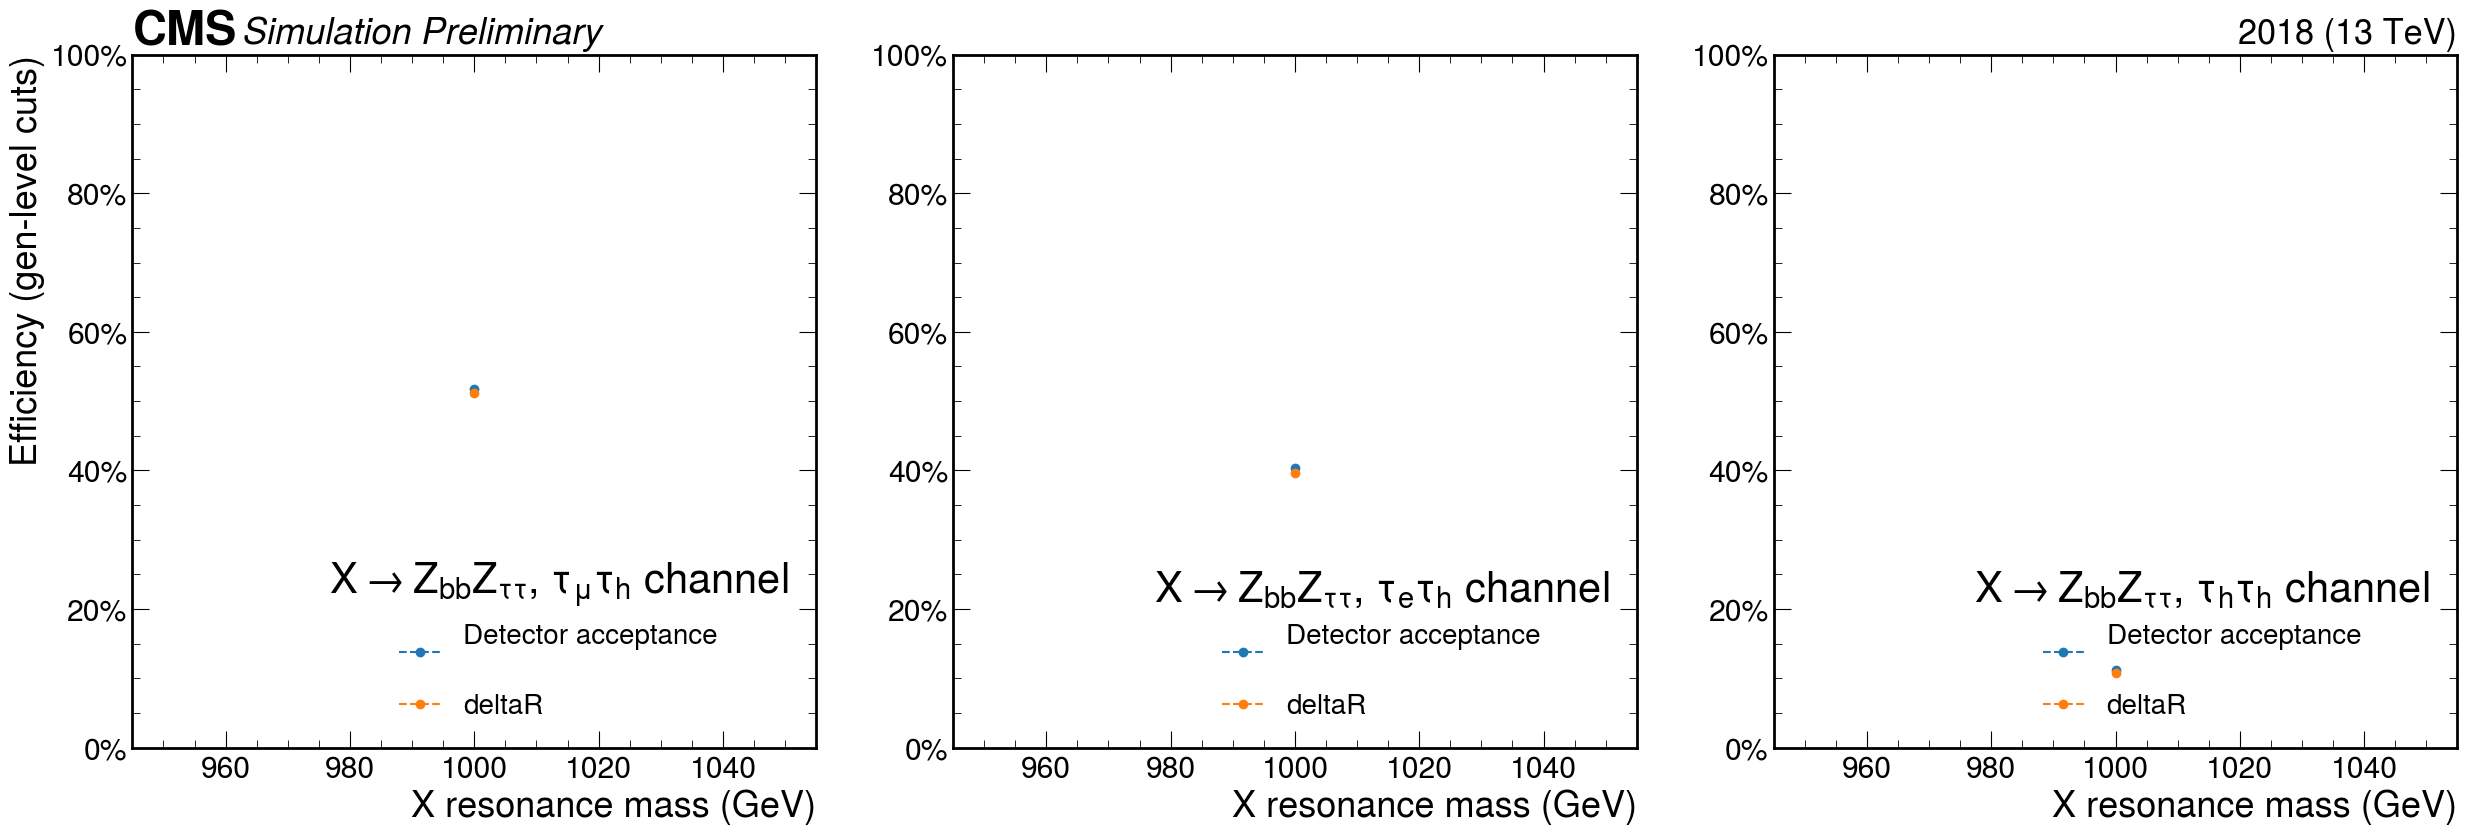

In [19]:
fig, (ax_mutau, ax_etau, ax_tautau) = plt.subplots(1, 3, figsize=(30, 9))


for pairType in range(3):
    cut_detector, cut_deltaR = dict(), dict()
    for mass, ar_nocut in ars_raw.items():
        ar = ar_nocut[ar_nocut.genPairType == pairType]

        ar_detector = ar[filterDetectorAcceptance(ar, pairType)]
        cut_detector[mass] = len(ar_detector)/len(ar)

        ar_deltaR = filterDeltaR(ar_detector, pairType)
        cut_deltaR[mass] = len(ar_deltaR)/len(ar)

    (ax_mutau, ax_etau, ax_tautau)[pairType].plot(cut_detector.keys(), cut_detector.values(), "o--", 
        label="Detector acceptance\n" #+ (
        #     r"$p_T^\mu>15 GeV$, $\left|\eta_\mu\right| < 2.4$"+"\n"+r"$p_T^{\tau_h} > 40 GeV$, $\left|\eta_{\tau_h}\right| < 2.5$",
        #     r"$p_T^e>20 GeV$, $\left|\eta_e\right| < 2.5$"+"\n"+r"$p_T^{\tau_h} > 40 GeV$, $\left|\eta_{\tau_h}\right| < 2.5$",
        #     r"$p_T^{\tau_h} > 40 GeV$, $\left|\eta_{\tau_h}\right| < 2.5$")[pairType]
        )
    (ax_mutau, ax_etau, ax_tautau)[pairType].plot(cut_deltaR.keys(), cut_deltaR.values(), "o--", label="deltaR", #(
            # r"$0.05 < \Delta R(\mu,\tau_h) < 0.7$",
            # r"$0.05 < \Delta R(e,\tau_h) < 0.6$",
            # r"$0.05 < \Delta R(\tau_h,\tau_h) < 0.6$",
    #    )[pairType]
    )

ax_mutau.set_ylabel("Efficiency (gen-level cuts)")
plt.rcParams['legend.title_fontsize'] = 30
plt.rcParams['legend.fontsize'] = 20
for ax in (ax_mutau, ax_etau, ax_tautau):
    plt.sca(ax)
    plt.xlabel("X resonance mass (GeV)")
    ax.set_ylim(0, 1)
    #plt.ylim(0, 1.3)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

ax_mutau.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel", loc="lower right", ncols=1)
ax_etau.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{e}\tau_{h}$ channel", loc="lower right", ncols=1)
ax_tautau.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{h}\tau_{h}$ channel", loc="lower right", ncols=1)
hep.cms.text("Simulation Preliminary",  ax=ax_mutau)
hep.cms.lumitext("2018 (13 TeV)", ax=ax_tautau)
#plt.savefig("studies/cutflow/cutflow_boostedTaus_detectorAcceptance.pdf", bbox_inches="tight")

<Axes: xlabel='X mass (GeV)'>

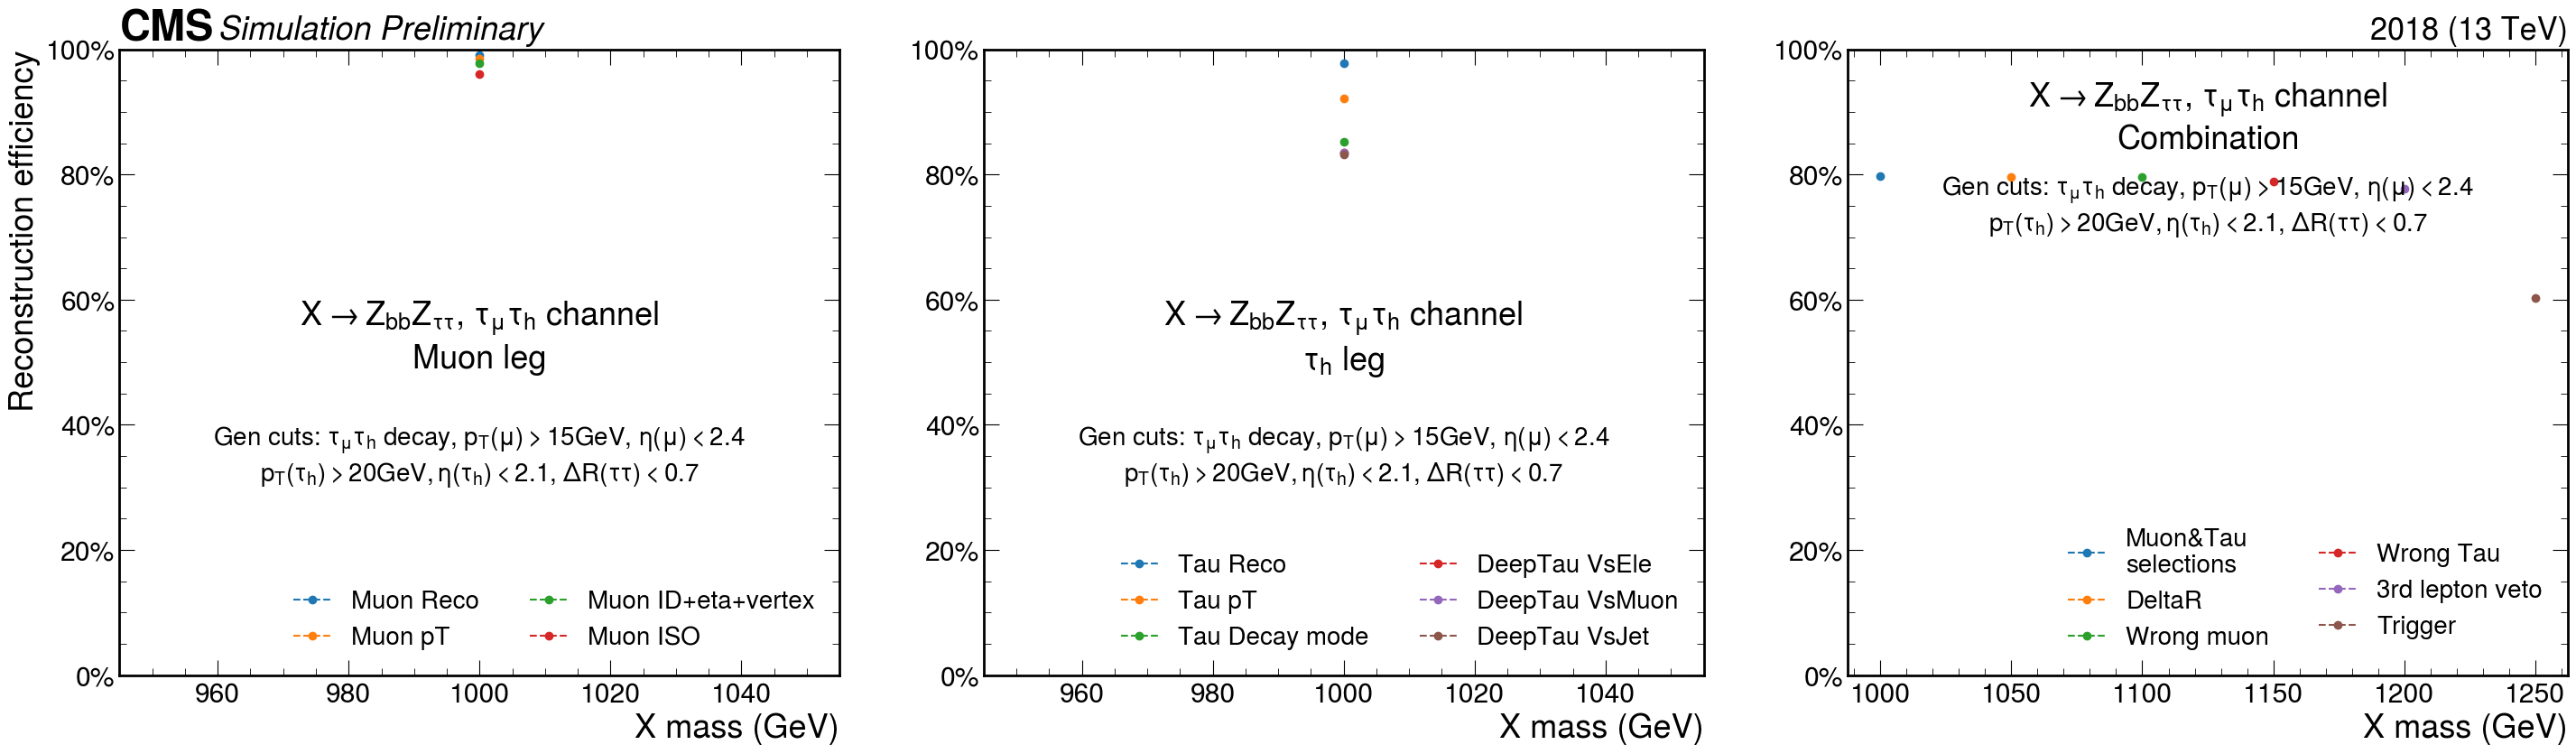

In [9]:
################# MuTau


fig, (ax_dau1, ax_dau2, ax_combined) = plt.subplots(1, 3, figsize=(35, 9))

### dau1
effs = defaultdict(dict)
cut_dau1 = dict()
for mass, ar in ars_mutau.items():
    if mass < min_mass_threshold: continue
    cut = ~ar.cutflow_HPSTaus_dau1_Reco
    effs["Muon Reco"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_Pt
    effs["Muon pT"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_Eta & ~ar.cutflow_HPSTaus_dau1_LeptonID & ~ar.cutflow_HPSTaus_dau1_Vertex
    effs["Muon ID+eta+vertex"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_LeptonIso
    effs["Muon ISO"][mass] = eff(cut, ar)

    cut_dau1[mass] = cut

for key, val in effs.items():
    ax_dau1.plot(val.keys(), val.values(), "o--", label=key)

## dau2
effs = defaultdict(dict)
cut_dau2 = dict()
for mass, ar in ars_mutau.items():
    if mass < min_mass_threshold: continue
    cut = ~ar.cutflow_HPSTaus_dau2_Reco & ~ar.cutflow_HPSTaus_dau2_Eta
    effs["Tau Reco"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_Pt
    effs["Tau pT"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauDM
    effs["Tau Decay mode"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauIdVsE
    effs["DeepTau VsEle"][mass] = eff(cut, ar)
    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauIdVsMu
    effs["DeepTau VsMuon"][mass] = eff(cut, ar)
    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauIdVsJet
    effs["DeepTau VsJet"][mass] = eff(cut, ar)

    cut_dau2[mass] = cut

for key, val in effs.items():
    ax_dau2.plot(val.keys(), val.values(), "o--", label=key)

## dau pair
effs = defaultdict(dict)
for mass, ar in ars_mutau.items():
    if mass < min_mass_threshold: continue
    cut = cut_dau1[mass] & cut_dau2[mass]
    effs["Muon&Tau\nselections"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_deltaR
    effs["DeltaR"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_WrongPair
    effs["Wrong muon"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_WrongPair
    effs["Wrong Tau"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_leptonVetoFail
    effs["3rd lepton veto"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_triggerFail
    effs["Trigger"][mass] = eff(cut, ar)

    #for closure test of cutflow
    # effs["Total"][mass] = eff((ar.pairType_HPSTaus == 0) &  passMETTrigger(ar) & passMETOffline(ar), ar)
delta_x = 0
for key, val in effs.items():
    ax_combined.plot(np.fromiter(val.keys(), dtype=float)+delta_x, val.values(), "o--", label=key)
    delta_x += 50

ax_dau1.set_ylabel("Reconstruction efficiency")
plt.rcParams['legend.title_fontsize'] = 'small'
plt.rcParams['legend.fontsize'] = 'x-small'
for i, ax in enumerate([ax_dau1, ax_dau2, ax_combined]):
    plt.sca(ax)
    plt.xlabel("X mass (GeV)")
    ax.set_ylim(bottom=0)
    plt.ylim(0, 1.)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

    ax.text(*(((0.5, 0.4), (0.5, 0.4), (0.5, 0.8))[i]),
        r"Gen cuts: $\tau_{\mu}\tau_{h}$ decay, $p_T(\mu) > 15 GeV$, $\eta(\mu) < 2.4$" "\n"
              r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.7$",
        transform=ax.transAxes, ha="center", va="top", fontsize=20)

    ax.legend(loc="lower right", ncols=2, fontsize=20)

ax_dau1.text(0.5, 0.6, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel" "\nMuon leg", transform=ax_dau1.transAxes, ha="center", va="top")
ax_dau2.text(0.5, 0.6, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel" "\n" r"$\tau_h$ leg", transform=ax_dau2.transAxes, ha="center", va="top")
ax_combined.text(0.5, 0.95, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel""\nCombination", transform=ax_combined.transAxes, ha="center", va="top")

# hep.cms.label("Preliminary", year=2018, ax=ax_dau1)
hep.cms.text("Simulation Preliminary",  ax=ax_dau1)
hep.cms.lumitext("2018 (13 TeV)", ax=ax_combined)
#plt.savefig("studies/cutflow/cutflow_HPSTaus_mutau.pdf", bbox_inches="tight")

<Axes: xlabel='X mass (GeV)'>

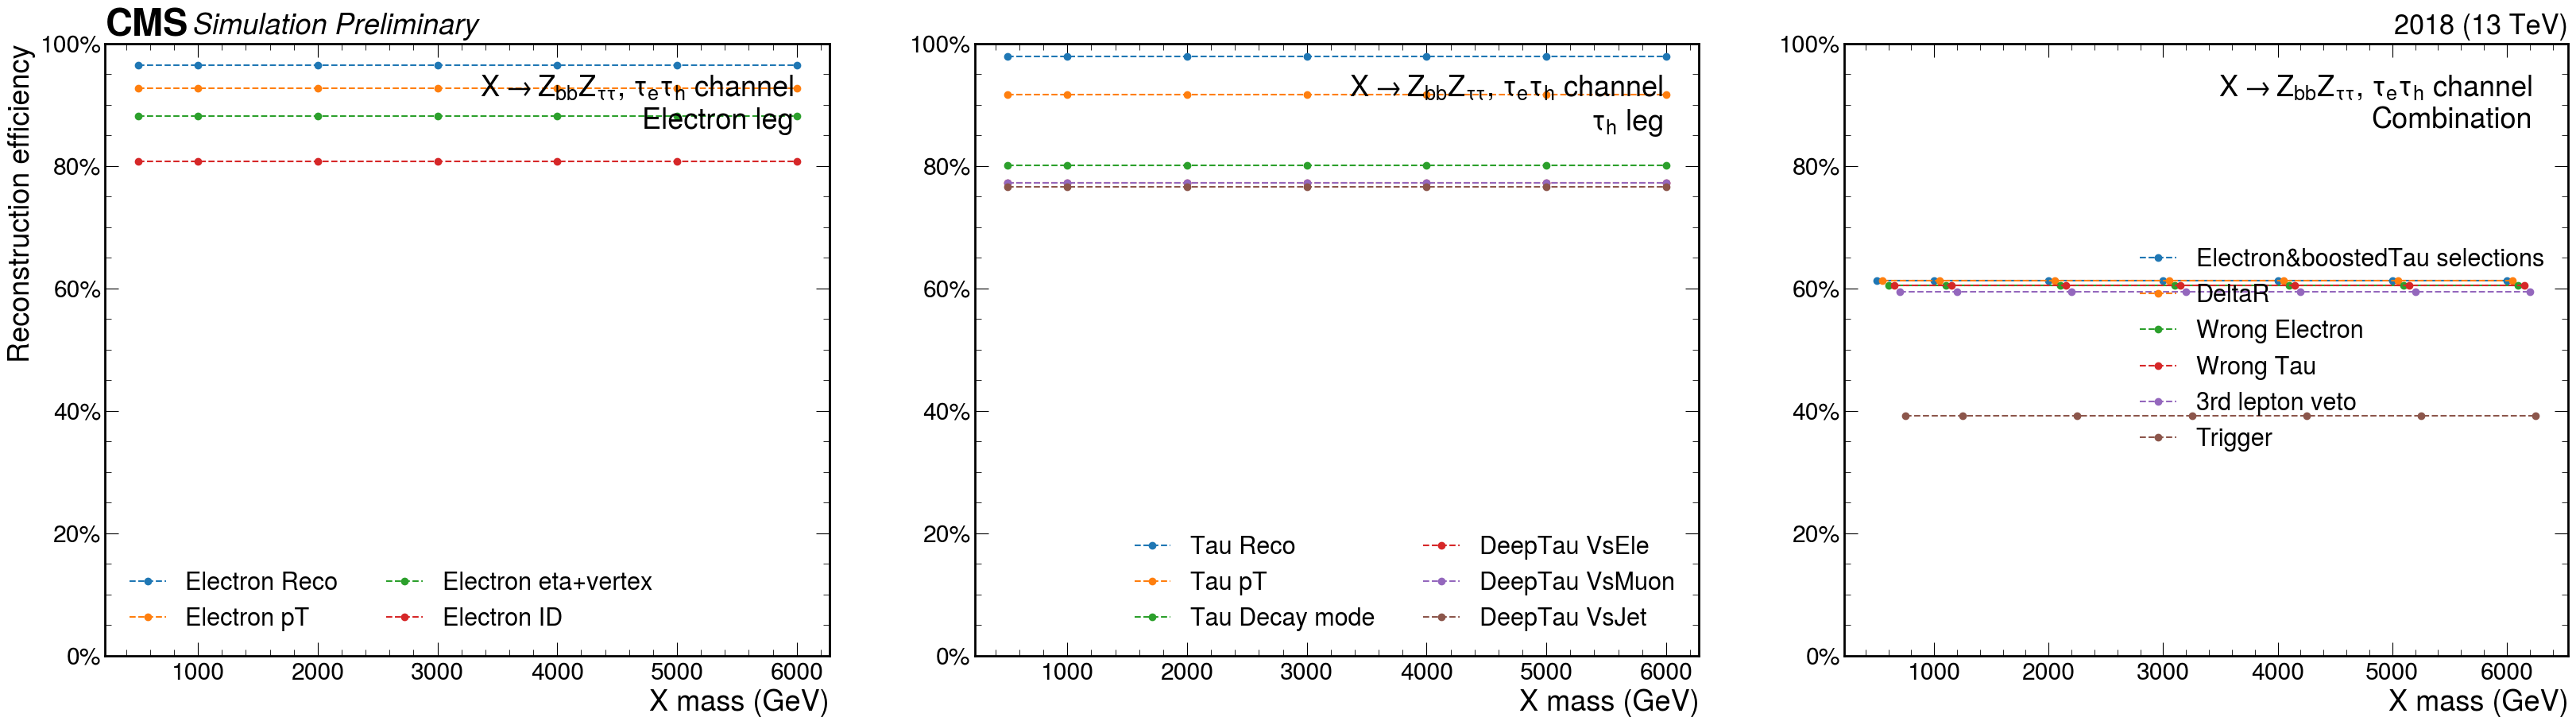

In [65]:
################# ETau
fig, (ax_dau1, ax_dau2, ax_combined) = plt.subplots(1, 3, figsize=(40, 10))

### dau1
effs = defaultdict(dict)
cut_dau1 = dict()
for mass, ar in ars_etau.items():
    if mass < min_mass_threshold: continue
    cut = ~ar.cutflow_HPSTaus_dau1_Reco
    effs["Electron Reco"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_Pt
    effs["Electron pT"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_Eta & ~ar.cutflow_HPSTaus_dau1_Vertex
    effs["Electron eta+vertex"][mass] = eff(cut, ar)

    cut = cut &  ~ar.cutflow_HPSTaus_dau1_LeptonID 
    effs["Electron ID"][mass] = eff(cut, ar)
    # no electron ISO (in MVA)
    # cut = cut & ~ar.cutflow_HPSTaus_dau1_LeptonIso
    # effs["Electron ISO"][mass] = eff(cut, ar)

    cut_dau1[mass] = cut

for key, val in effs.items():
    ax_dau1.plot(val.keys(), val.values(), "o--", label=key)

## dau2
effs = defaultdict(dict)
cut_dau2 = dict()
for mass, ar in ars_etau.items():
    if mass < min_mass_threshold: continue
    cut = ~ar.cutflow_HPSTaus_dau2_Reco & ~ar.cutflow_HPSTaus_dau2_Eta
    effs["Tau Reco"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_Pt
    effs["Tau pT"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauDM
    effs["Tau Decay mode"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauIdVsE
    effs["DeepTau VsEle"][mass] = eff(cut, ar)
    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauIdVsMu
    effs["DeepTau VsMuon"][mass] = eff(cut, ar)
    cut = cut & ~ar.cutflow_HPSTaus_dau2_TauIdVsJet
    effs["DeepTau VsJet"][mass] = eff(cut, ar)

    cut_dau2[mass] = cut

for key, val in effs.items():
    ax_dau2.plot(val.keys(), val.values(), "o--", label=key)

## dau pair
effs = defaultdict(dict)
for mass, ar in ars_etau.items():
    if mass < min_mass_threshold: continue
    cut = cut_dau1[mass] & cut_dau2[mass]
    effs["Electron&boostedTau selections"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_deltaR
    effs["DeltaR"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_WrongPair
    effs["Wrong Electron"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau2_WrongPair
    effs["Wrong Tau"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_leptonVetoFail
    effs["3rd lepton veto"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_triggerFail
    effs["Trigger"][mass] = eff(cut, ar)

    # effs["Total"][mass] = eff(ar.pairType_HPSTaus == 1, ar)
delta_x = 0
for key, val in effs.items():
    ax_combined.plot(np.fromiter(val.keys(), dtype=float)+delta_x, val.values(), "o--", label=key)
    delta_x += 50

ax_dau1.set_ylabel("Reconstruction efficiency")
plt.rcParams['legend.title_fontsize'] = 'small'
plt.rcParams['legend.fontsize'] = 'x-small'
for i, (ax, leg_pos) in enumerate([(ax_dau1, "lower left"), (ax_dau2, "lower right"), (ax_combined, "center right")]):
    plt.sca(ax)
    plt.xlabel("X mass (GeV)")
    
    ax.set_ylim(bottom=0, top=1)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

    # if i == 1:
    #     ax.text(*(((0.1, 0.4), (0.5, 0.4), (0.5, 0.8))[i]),
    #         r"Gen cuts: $\tau_{e}\tau_{h}$ decay, $p_T(e) > 20 GeV$, $\eta(e) < 2.5$" "\n"
    #             r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$",
    #         transform=ax.transAxes, ha="center", va="top", fontsize=20)

    ax.legend(loc=leg_pos, ncols=2 if i <= 1 else 1, fontsize=22)

    ax.text(0.95, 0.95, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{e}\tau_{h}$ channel" "\n" + (("Electron leg", r"$\tau_h$ leg", "Combination")[i]), transform=ax.transAxes, ha="right", va="top")

# ax_dau1.text(0.5, 0.5, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel", transform=ax_dau1.transAxes, ha="center")
# ax_dau2.text(0.5, 0.5, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel", transform=ax_dau2.transAxes, ha="center")
# ax_combined.text(0.5, 0.9, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel", transform=ax_combined.transAxes, ha="center")


# hep.cms.label("Preliminary", year=2018, ax=ax_dau1)
hep.cms.text("Simulation Preliminary",  ax=ax_dau1)
hep.cms.lumitext("2018 (13 TeV)", ax=ax_combined)
#plt.savefig("studies/cutflow/cutflow_HPSTaus_etau.pdf", bbox_inches="tight")

In [54]:
a = ars_etau[500][ars_etau[500].pairType == 1]

In [60]:
ak.count_nonzero(a.cutflow_HPSTaus_dau2_Reco)

121

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

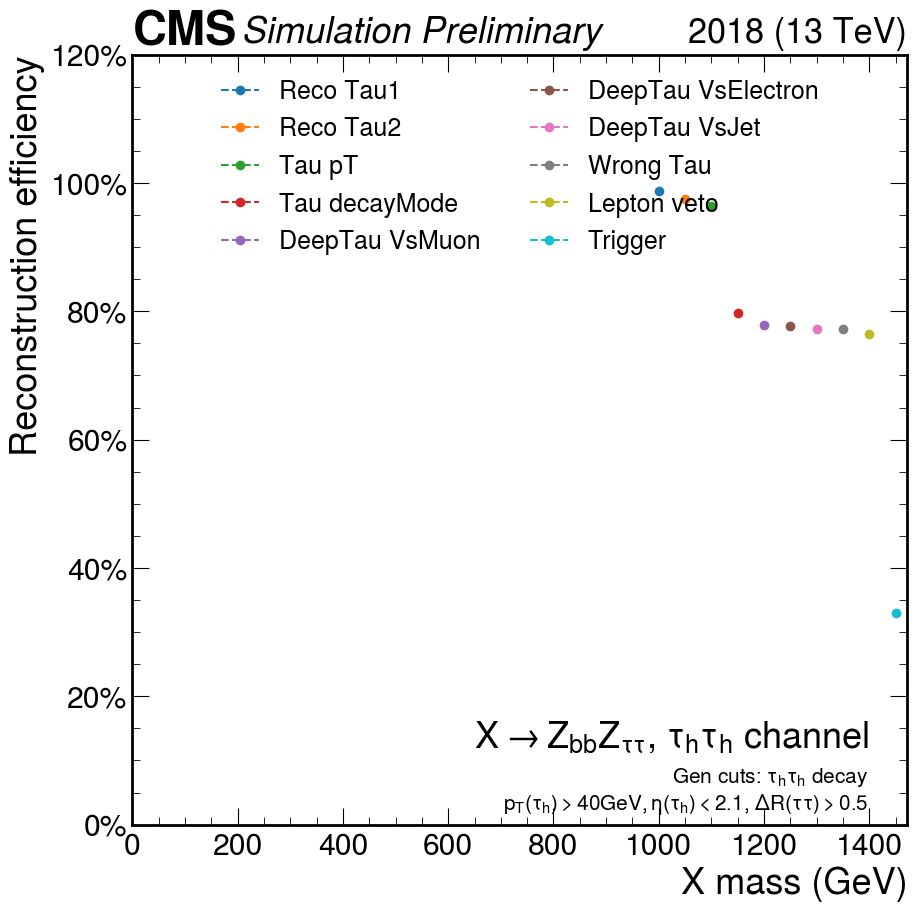

In [21]:
################# TAUS
effs = defaultdict(dict)
for mass, ar in ars_tautau.items():
    if mass < min_mass_threshold: continue
    cut = ~ar.cutflow_HPSTaus_dau1_Reco
    effs["Reco Tau1"][mass] = eff(cut, ar)
    cut = cut & (~ar.cutflow_HPSTaus_dau2_Reco) & ~ar.cutflow_HPSTaus_deltaR 
    effs["Reco Tau2"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_Pt & ~ar.cutflow_HPSTaus_dau2_Pt
    effs["Tau pT"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_TauDM & ~ar.cutflow_HPSTaus_dau2_TauDM
    effs["Tau decayMode"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_TauIdVsMu & ~ar.cutflow_HPSTaus_dau2_TauIdVsMu
    effs["DeepTau VsMuon"][mass] = eff(cut, ar)
    cut = cut & ~ar.cutflow_HPSTaus_dau1_TauIdVsMu & ~ar.cutflow_HPSTaus_dau2_TauIdVsE
    effs["DeepTau VsElectron"][mass] = eff(cut, ar)
    cut = cut & ~ar.cutflow_HPSTaus_dau1_TauIdVsJet & ~ar.cutflow_HPSTaus_dau2_TauIdVsJet
    effs["DeepTau VsJet"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_dau1_WrongPair & ~ar.cutflow_HPSTaus_dau2_WrongPair
    effs["Wrong Tau"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_leptonVetoFail 
    effs["Lepton veto"][mass] = eff(cut, ar)

    cut = cut & ~ar.cutflow_HPSTaus_triggerFail
    effs["Trigger"][mass] = eff(cut, ar)

delta_x = 0
for key, val in effs.items():
    plt.plot(np.fromiter(val.keys(), dtype=float)+delta_x, val.values(), "o--", label=key)
    delta_x += 50
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Reconstruction efficiency")
plt.ylim(0, 1.2)
plt.xlim(left=0)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.text(0.95, 0.01,
              r"Gen cuts: $\tau_{h}\tau_{h}$ decay" "\n"
              r"$p_T(\tau_h) > 40 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)>0.5$",
            transform=plt.gca().transAxes, ha="right", va="bottom", fontsize=15)

plt.text(0.95, 0.1, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{h}\tau_{h}$ channel", transform=plt.gca().transAxes, ha="right")

plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(loc="upper center", ncols=2, fontsize=18)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_boostedTaus_tautau.pdf")

## Channel migration

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

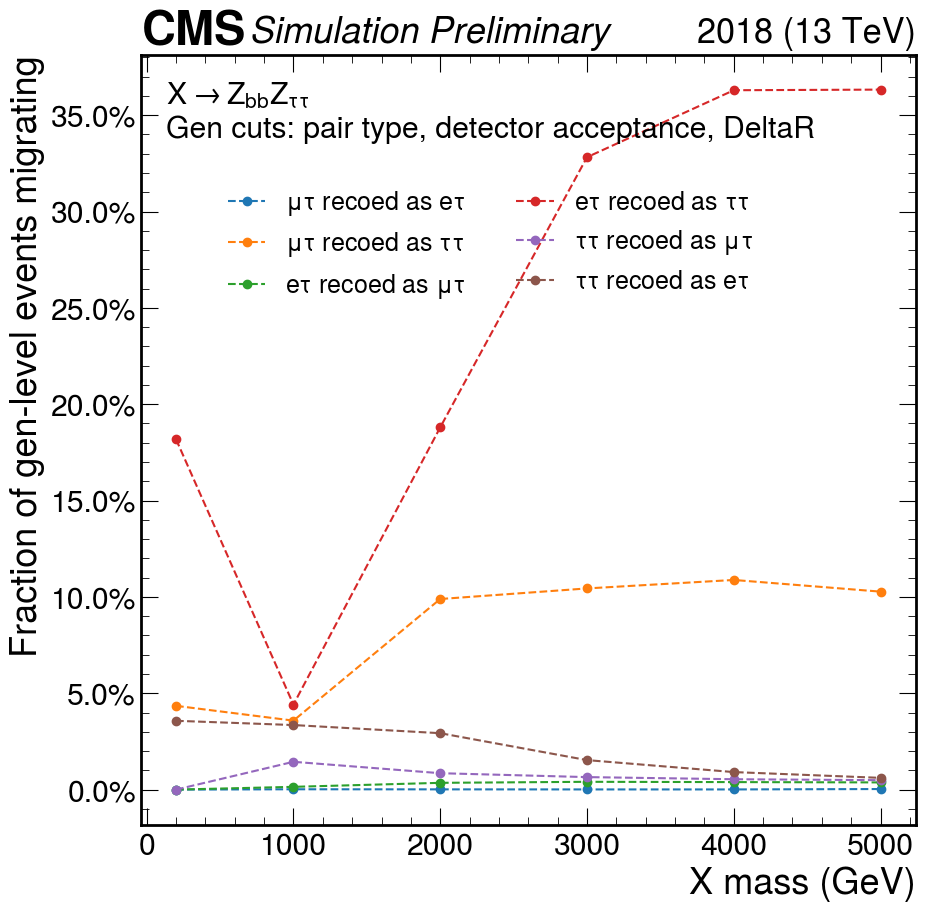

In [44]:
pairType_leg = {1:r"$e\tau$", 0:r"$\mu\tau$", 2:r"$\tau\tau$"}
effs = defaultdict(dict)
for mass in ars_tautau.keys():
    for pairType_gen in range(3):
        for pairType_reco in range(3):
            if pairType_gen == pairType_reco: continue
            ar_gen = ars_pairType[pairType_gen][mass]
            effs[f"{pairType_leg[pairType_gen]} recoed as {pairType_leg[pairType_reco]}"][mass] = eff(ar_gen.pairType_boostedTaus==pairType_reco, ar_gen)
            

for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Fraction of gen-level events migrating")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$" "\n" 
               r"Gen cuts: pair type, detector acceptance, DeltaR" "\n"
            #   r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$"
              , loc="upper left", ncols=2)

hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

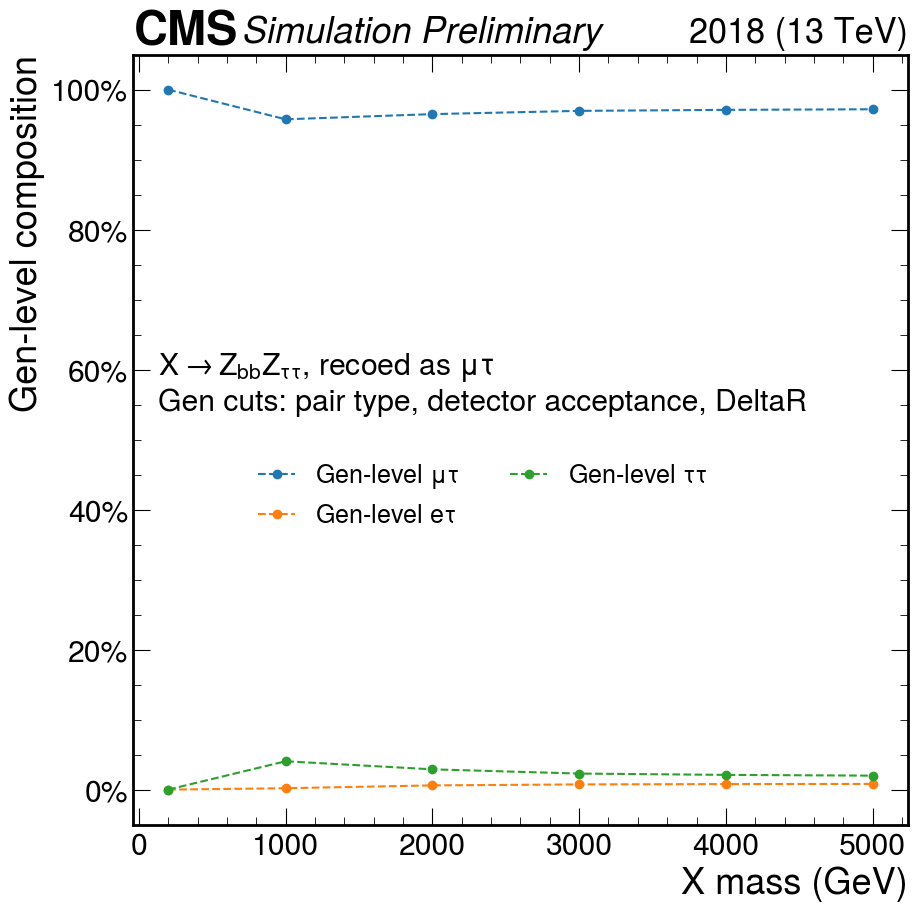

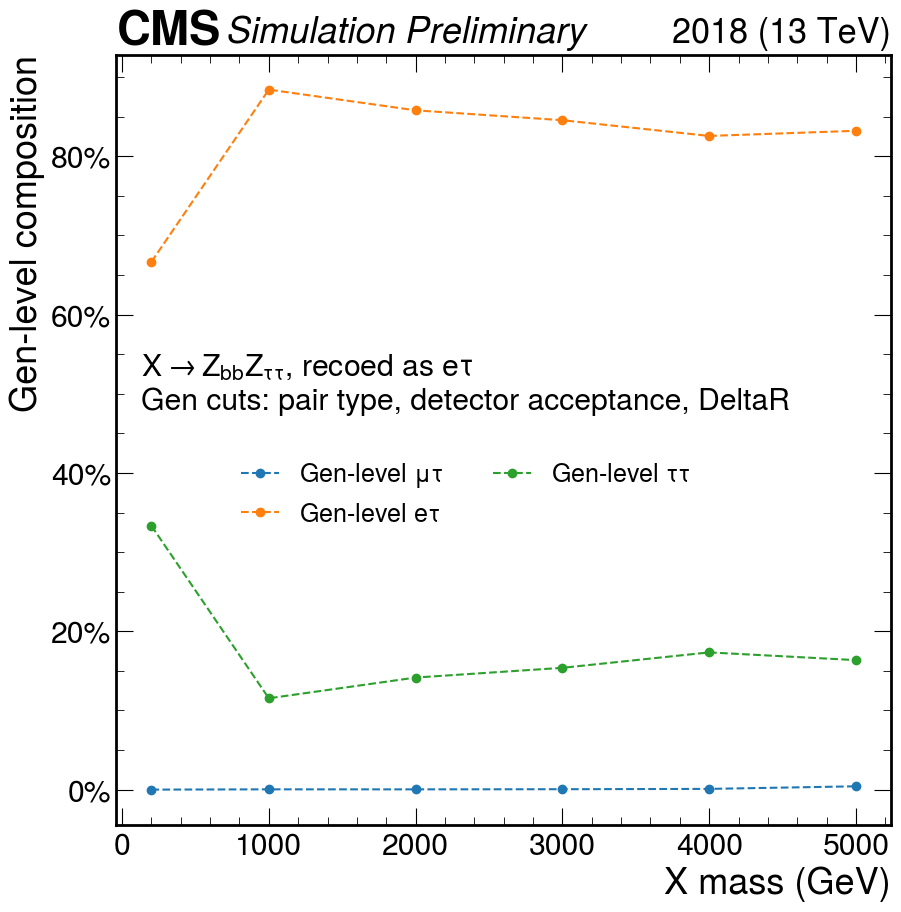

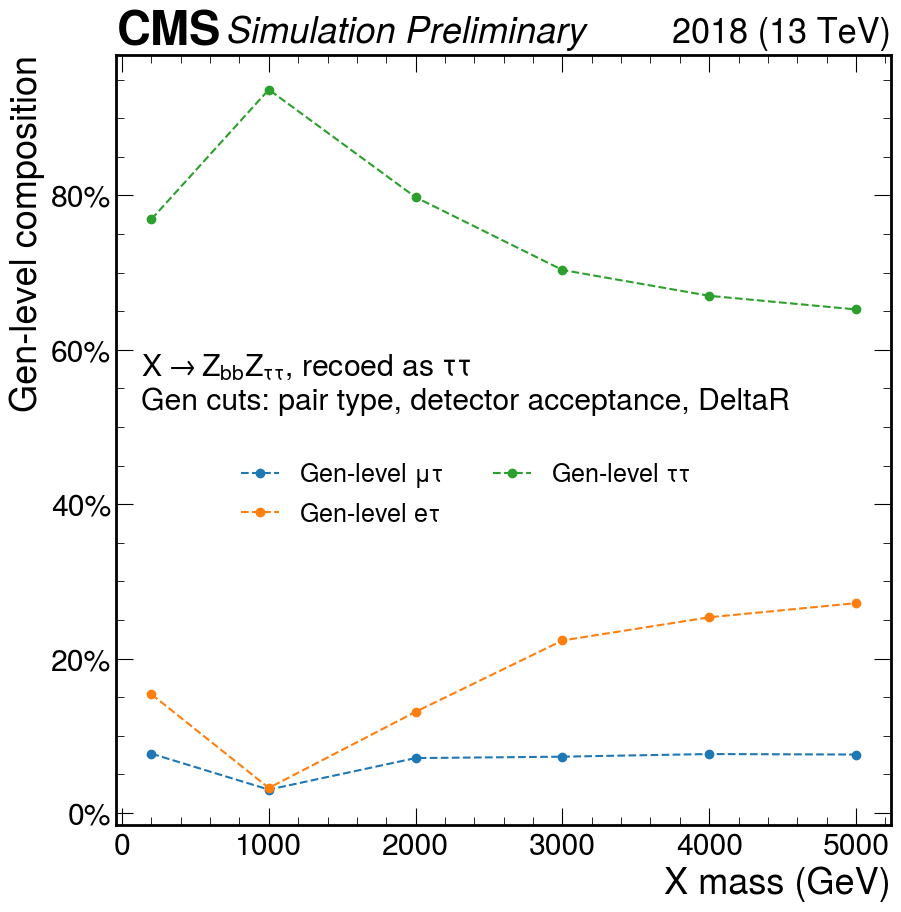

In [45]:
for pairType_reco in range(3):
    plt.figure()

    for pairType_gen in range(3): 
        effs = dict()
        for mass in ars_tautau.keys():
            total_pairType_reco = sum(ak.count_nonzero(ars[mass].pairType_boostedTaus==pairType_reco) for ars in ars_pairType.values()) # sum of events in pairType_reco
            
            ar_gen = ars_pairType[pairType_gen][mass]
            effs[mass] = ak.count_nonzero(ar_gen.pairType_boostedTaus==pairType_reco) / total_pairType_reco
            #print(ar_gen.pairType_boostedTaus==pairType_reco, ak.count_nonzero(ar_gen.pairType_boostedTaus==pairType_reco), total_pairType_reco, list(ak.count_nonzero(ars[mass].pairType_boostedTaus>=0) for ars in ars_pairType.values()))
            #print(ak.count_nonzero(ar_gen.pairType_boostedTaus==pairType_reco), total_pairType_reco, list(ak.count_nonzero(ars[mass].pairType_boostedTaus>=0) for ars in ars_pairType.values()))

        plt.plot(effs.keys(), effs.values(), "o--", label="Gen-level "+pairType_leg[pairType_gen])

    plt.xlabel("X mass (GeV)")
    plt.ylabel("Gen-level composition")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.rcParams['legend.title_fontsize'] = 'small'
    plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, recoed as " + pairType_leg[pairType_reco] + "\n" 
                r"Gen cuts: pair type, detector acceptance, DeltaR" "\n"
                #   r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$"
                , loc="center left", ncols=2)

    hep.cms.label("Preliminary", year=2018)      


# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")

#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

## DeltaR distribution

In [23]:
ar = ars_raw[3000][ars_raw[3000].GenPairType == 0]
genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))

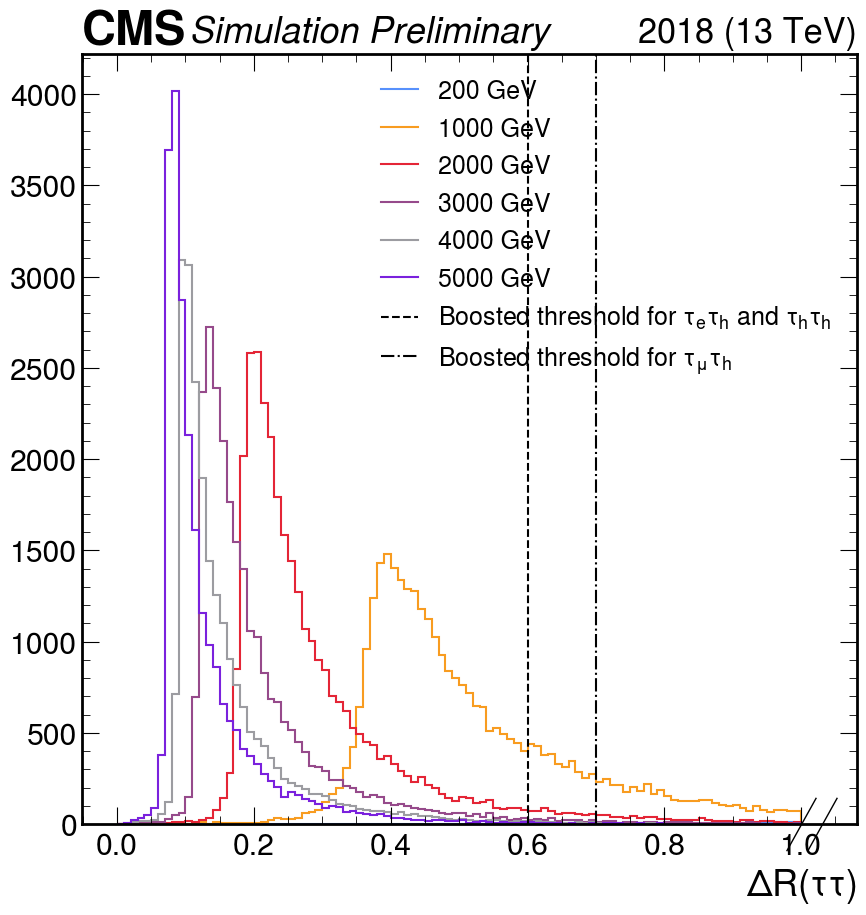

In [24]:
hs = dict()
for mass, ar_nofilter in ars_raw.items():
    cut = (ar_nofilter.GenPairType == 1) 

    cut = ~ar_nofilter.cutflow_boostedTaus_dau1_Reco
    cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Pt
    cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Eta & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonID & ~ar_nofilter.cutflow_boostedTaus_dau1_Vertex
    cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonIso

    ar = ar_nofilter[cut]

    genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
    deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))
    h = hist.Hist(hist.axis.Regular(100, 0., 1., label=r"$\Delta R (\tau\tau)$"))
    h.fill(deltaR)
    hs[mass] = h
hep.histplot(list(hs.values()), label=[str(m) + " GeV" for m in hs.keys()], yerr=False)
plt.axvline(0.6, ls="--", color="black", label=r"Boosted threshold for $\tau_e \tau_h$ and $\tau_h \tau_h$")
plt.axvline(0.7, ls="-.", color="black", label=r"Boosted threshold for $\tau_\mu \tau_h$")
hep.cms.label("Preliminary", year=2018)
plt.legend()
#plt.xscale("log")

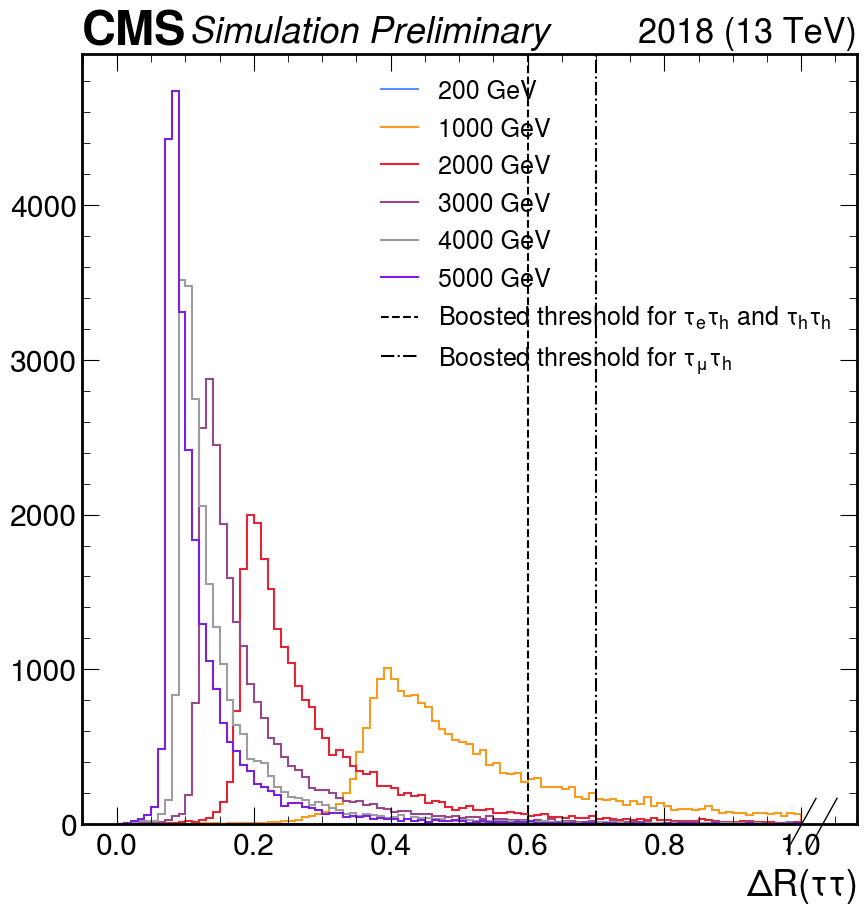

In [25]:
hs = dict()
for mass, ar_nofilter in ars_raw.items():
    cut = (ar_nofilter.GenPairType == 0) 

    # cut = ~ar_nofilter.cutflow_boostedTaus_dau1_Reco
    # cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Pt
    # cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_Eta & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonID & ~ar_nofilter.cutflow_boostedTaus_dau1_Vertex
    # cut = cut & ~ar_nofilter.cutflow_boostedTaus_dau1_LeptonIso

    ar = ar_nofilter[cut]

    genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
    deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))
    h = hist.Hist(hist.axis.Regular(100, 0., 1., label=r"$\Delta R (\tau\tau)$"))
    h.fill(deltaR)
    hs[mass] = h
hep.histplot(list(hs.values()), label=[str(m) + " GeV" for m in hs.keys()], yerr=False)
plt.axvline(0.6, ls="--", color="black", label=r"Boosted threshold for $\tau_e \tau_h$ and $\tau_h \tau_h$")
plt.axvline(0.7, ls="-.", color="black", label=r"Boosted threshold for $\tau_\mu \tau_h$")
hep.cms.label("Preliminary", year=2018)
plt.legend()
#plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

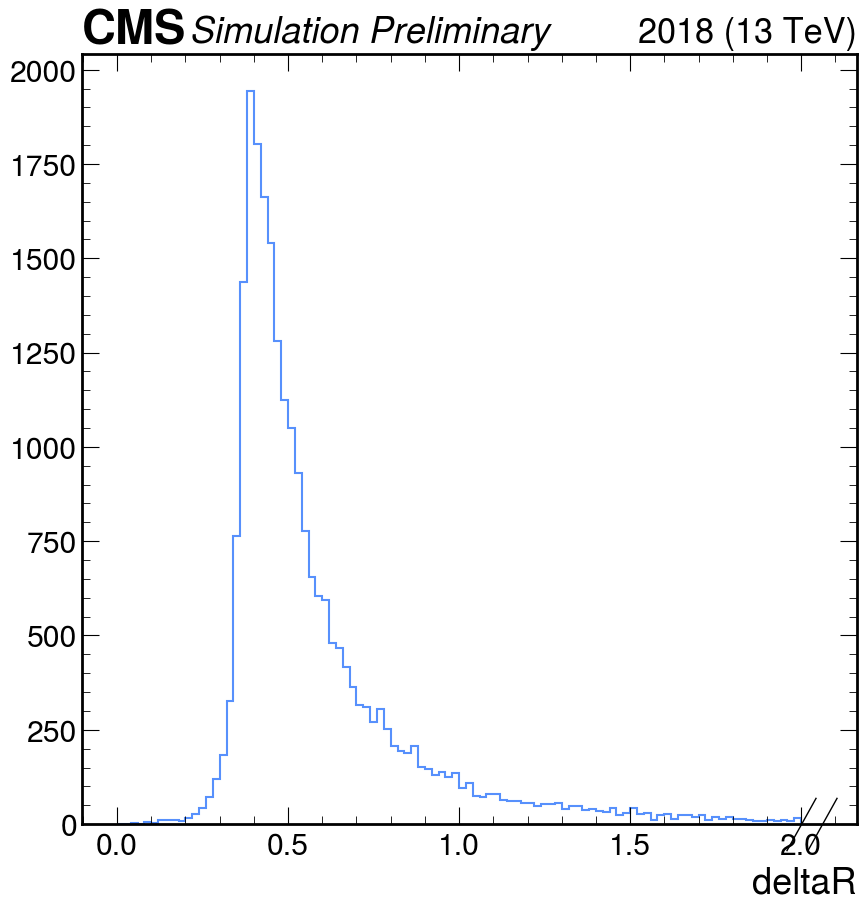

In [26]:
ar = ars_raw[1000]
ar = ar[ar.GenPairType == 0]
genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_genPartIdx, ar.genDau1_genPartIdx >= 0))])
genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_genPartIdx, ar.genDau2_genPartIdx >= 0))])
deltaR = ak.drop_none(delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi))
h = hist.Hist(hist.axis.Regular(100, 0., 2., label="deltaR"))
h.fill(deltaR)
hep.histplot(h, yerr=False)
hep.cms.label("Preliminary", year=2018)

## DeepBoostedTau score

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'),
 supptext: Custom Text(1.012, 1, ''))

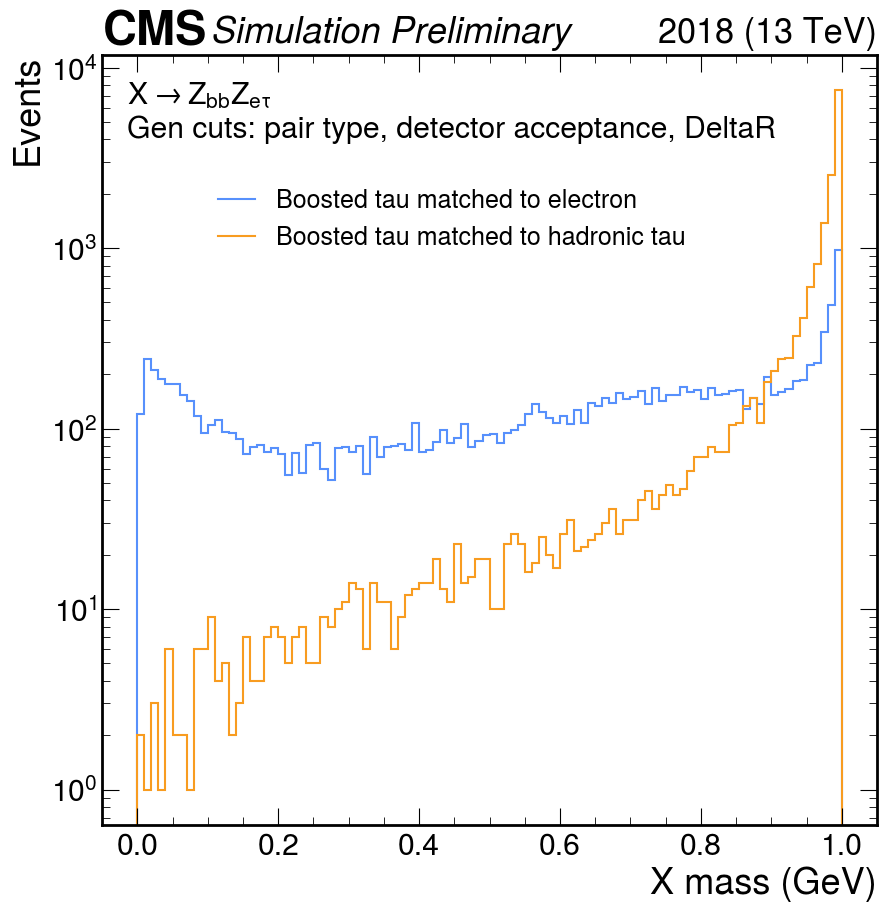

In [28]:
ar = ars_etau[3000]
h_ele = hist.Hist(hist.axis.Regular(100, 0., 1., label="Vs electron score"))
h_ele.fill(ak.flatten(ar.boostedTau.rawDeepTau2018v2p7VSe[ar.boostedTau.genPartFlav == 3]))
h_tauh = hist.Hist(hist.axis.Regular(100, 0., 1., label="Vs electron score"))
h_tauh.fill(ak.flatten(ar.boostedTau.rawDeepTau2018v2p7VSe[ar.boostedTau.genPartFlav == 5]))
hep.histplot([h_ele, h_tauh], yerr=False, label=["Boosted tau matched to electron", "Boosted tau matched to hadronic tau"])
plt.legend()
plt.yscale("log")
plt.xlabel("X mass (GeV)")
plt.ylabel("Events")
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{e\tau}$" "\n" 
               r"Gen cuts: pair type, detector acceptance, DeltaR" "\n"
            #   r"$p_T(\tau_h) > 20 GeV, \eta(\tau_h) < 2.1$, $\Delta R(\tau\tau)<0.6$"
              , loc="upper left", ncols=1)

hep.cms.label("Preliminary", year=2018)

# Full chain efficiency

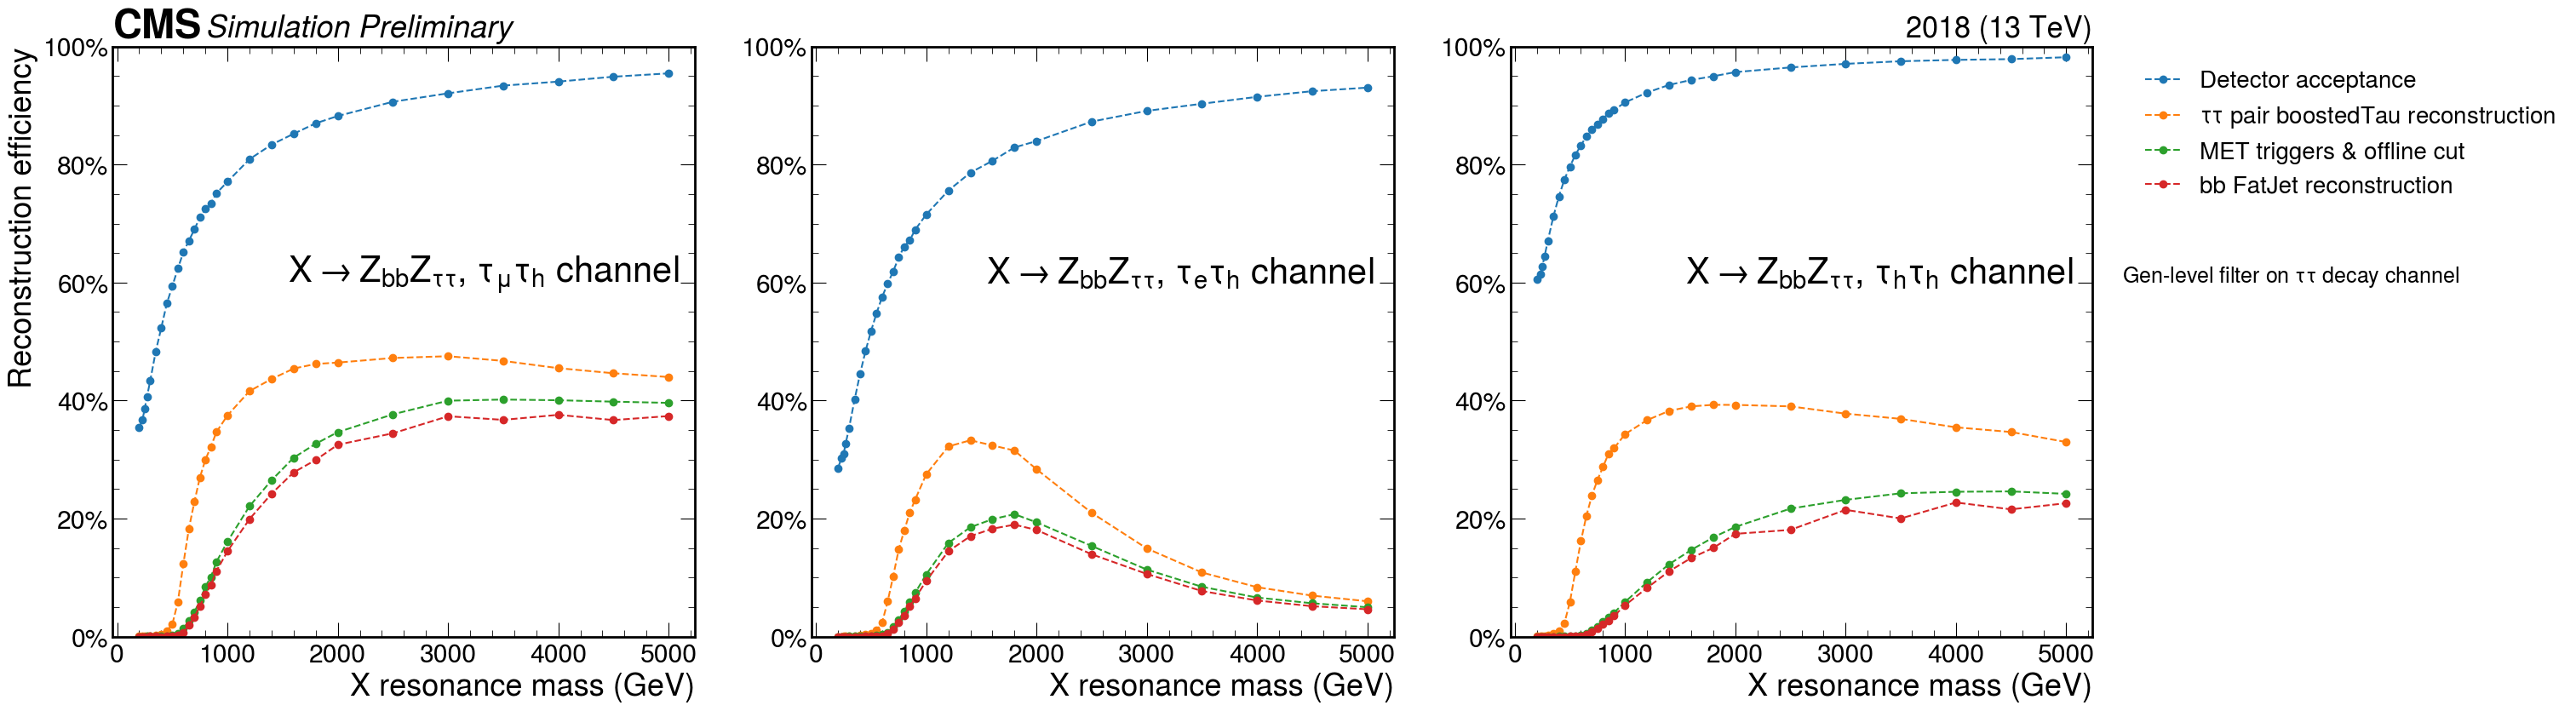

In [147]:
fig, (ax_mutau, ax_etau, ax_tautau) = plt.subplots(1, 3, figsize=(30, 9))


for pairType in range(3):
    effs = defaultdict(dict)
    for mass, ar in ars_raw.items():
        #if mass < min_mass_threshold: continue
        ar_genPair = ar[ar.genPairType == pairType]
        ar_det = filterDetectorAcceptance(ar_genPair, pairType)
        effs["Detector acceptance"][mass] = len(ar_det) / len(ar_genPair)

        cut = (ar_det.pairType_boostedTaus == pairType)
        effs[r"$\tau\tau$ pair boostedTau reconstruction"][mass] = eff(cut, ar_genPair)
            
        cut = cut & passMETTrigger(ar_det) & passMETOffline(ar_det)
        effs["MET triggers & offline cut"][mass] = eff(cut, ar_genPair)

        cut = cut & (ar_det.fatjet_JetIdx>=0)
        effs["bb FatJet reconstruction"][mass] = eff(cut, ar_genPair)

        #effs["Total"][mass] = eff((ar_det.isBoostedTau) & (ar_det.isBoosted), ar_genPair)
    
    for key, val in effs.items():
        (ax_mutau, ax_etau, ax_tautau)[pairType].plot(val.keys(), val.values(), "o--", label=key)


ax_mutau.set_ylabel("Reconstruction efficiency")
plt.rcParams['legend.title_fontsize'] = 30
plt.rcParams['legend.fontsize'] = 20
for ax in (ax_mutau, ax_etau, ax_tautau):
    plt.sca(ax)
    plt.xlabel("X resonance mass (GeV)")
    ax.set_ylim(0, 1)
    #plt.ylim(0, 1.3)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

ax_mutau.text(0.3, 0.6, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel", transform=ax_mutau.transAxes, fontsize=30)
ax_etau.text(0.3, 0.6, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{e}\tau_{h}$ channel", transform=ax_etau.transAxes, fontsize=30)
ax_tautau.text(0.3, 0.6, r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{h}\tau_{h}$ channel", transform=ax_tautau.transAxes, fontsize=30)
# ax_mutau.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel", loc="lower right", ncols=1)
# ax_etau.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{e}\tau_{h}$ channel", loc="lower right", ncols=1)
ax_tautau.legend(bbox_to_anchor=(1.05, 1.), ncols=1, fontsize=20)
ax_tautau.text(1.05, 0.6, r"Gen-level filter on $\tau\tau$ decay channel", transform=ax_tautau.transAxes, fontsize=18)
hep.cms.text("Simulation Preliminary",  ax=ax_mutau)
hep.cms.lumitext("2018 (13 TeV)", ax=ax_tautau)
plt.savefig("studies/cutflow/cutflow_boostedTaus_boostedbb_boostedTau.pdf", bbox_inches="tight")

# HPSTaus